In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, classification_report, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.linear_model import LogisticRegression
import joblib

# Data Import

In [2]:
#Import the data from a csv file into a DataFrame
df = pd.read_csv("Project_1_Data.csv")

# Data Analysis & Visualization

In [3]:
#Display the structure and statistical summary of the data 
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       860 non-null    float64
 1   Y       860 non-null    float64
 2   Z       860 non-null    float64
 3   Step    860 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 27.0 KB


,X,Y,Z,Step
count,860.000000,860.000000,860.000000,860.000000
mean,5.587116,4.845605,1.197465,7.756977
std,3.719067,1.142329,0.522844,2.407837
min,0.000000,3.062500,0.000000,1.000000
25%,1.562500,3.062500,0.783800,7.000000
50%,7.770000,5.125000,1.220000,8.000000
75%,8.575000,5.845000,1.616975,9.000000
max,9.375000,5.845000,2.350000,13.000000


In [4]:
#Distribution of the labels in the dataset
df["Step"].value_counts()

Step
9     251
8     221
7     148
1      24
2      24
3      24
4      24
5      24
6      24
10     24
11     24
12     24
13     24
Name: count, dtype: int64

<Axes: >

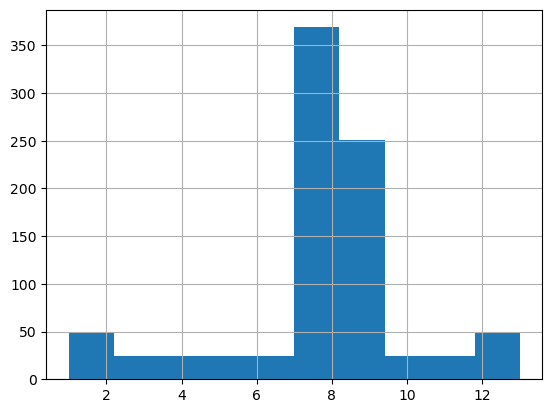

In [5]:
#Distribution of each step in the dataset
df["Step"].hist()

From the above, it can be seen that steps 7, 8, and 9 have more rows than the others. This could imply that these steps involve more movement/finer adjustments. In order to 
ensure all steps are proportionally represented, this will be used for the stratified sampling of the data

<Axes: >

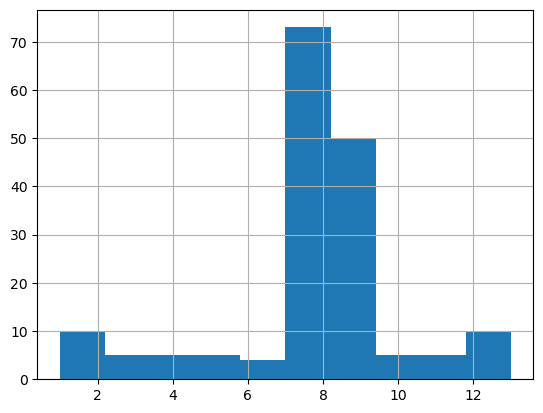

In [6]:
#Create an 80/20 train/test split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df["Step"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

#Confirm the test set has the same class distribution as the original data 
test_set["Step"].hist()

In [7]:
#Create a copy of the training data for exploration
exp_set  = train_set.copy()

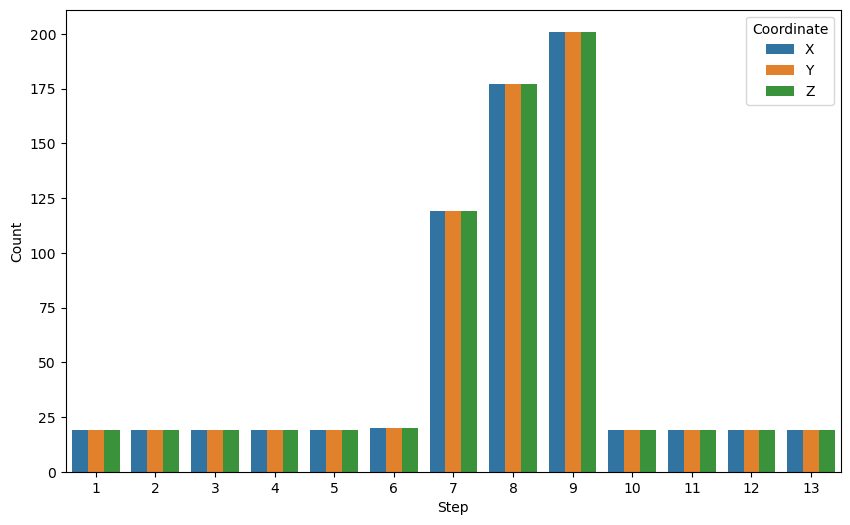

In [8]:
#Visualizing the distribution of the classes, as well as features per class
coord_counts = exp_set.groupby('Step')[['X', 'Y', 'Z']].count().reset_index()

melted = pd.melt(coord_counts, id_vars = 'Step', value_vars = ['X', 'Y', 'Z'], var_name = 'Coordinate', value_name = 'Count')

plt.figure(figsize=(10, 6))
sns.barplot(x = 'Step', y = 'Count', hue = 'Coordinate', data = melted)

plt.show()

I would like to first visualze the range of each axis per step, to see if there are any correlations. For example, if Step 5 involves a lot of translation in the x-axis, but
minimal movement in the others

In [9]:
#Determining min and max for each feature, grouped by class
coord_range = exp_set.groupby('Step')[['X', 'Y', 'Z']].agg(
    X_min = ('X', 'min'),
    X_max = ('X', 'max'),
    Y_min = ('Y', 'min'),
    Y_max = ('Y', 'max'),
    Z_min = ('Z', 'min'),
    Z_max = ('Z', 'max'),
).reset_index()

#Visualize the range of each feature per class
coord_range

,Step,X_min,X_max,Y_min,Y_max,Z_min,Z_max
0,1,9.375,9.375,3.0625,3.0625,0.50,0.72
1,2,9.375,9.375,3.0625,3.0625,0.74,0.97
2,3,9.375,9.375,3.0625,3.0625,0.98,1.21
3,4,9.375,9.375,3.0625,3.0625,1.22,1.45
4,5,9.375,9.375,3.0625,3.0625,1.46,1.69
5,6,9.375,9.375,3.0625,3.0625,1.71,1.92
6,7,8.575,8.575,5.6250,5.6250,0.36,1.82
7,8,6.945,9.145,5.1250,5.1250,0.35,2.00
8,9,0.375,2.875,5.8450,5.8450,0.00,2.35
9,10,0.000,0.000,3.0625,3.0625,0.98,1.21


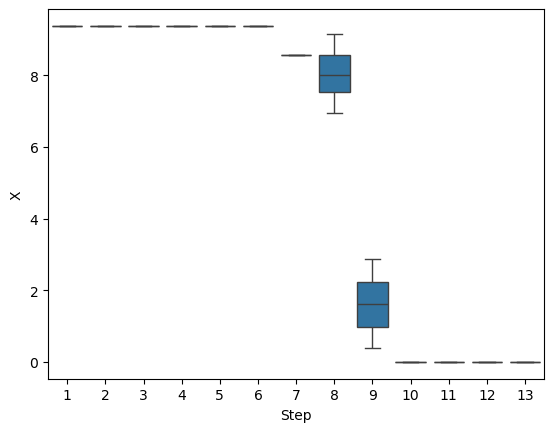

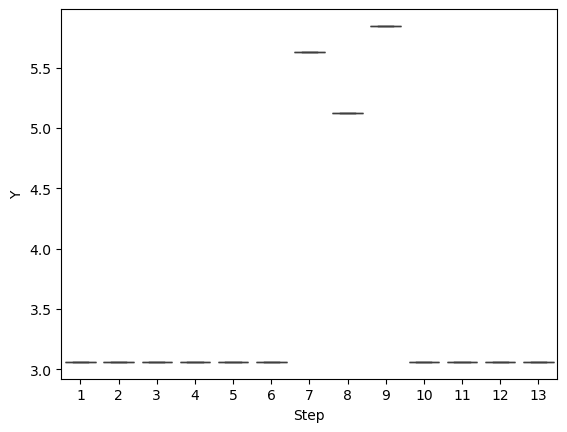

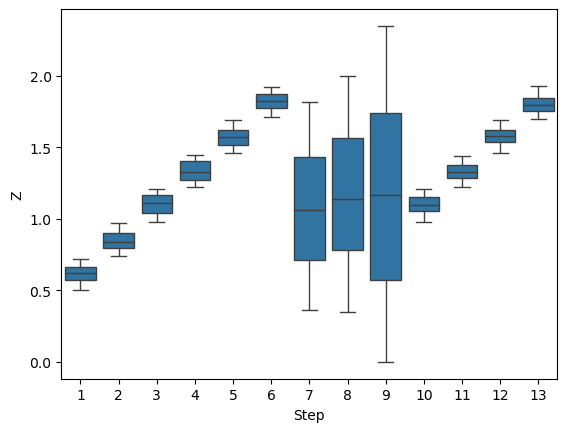

In [67]:
sns.boxplot(exp_set, x='Step', y='X')
plt.show()

sns.boxplot(exp_set, x='Step', y='Y')
plt.show()

sns.boxplot(exp_set, x='Step', y='Z')
plt.show()

# Correlation Analysis 

In [10]:
#Generate and display the correlation matrix for the dataset
corr_matrix = exp_set.corr()

corr_matrix["Step"].sort_values(ascending = False)

Step    1.000000
Y       0.294097
Z       0.192925
X      -0.749724
Name: Step, dtype: float64

<Axes: >

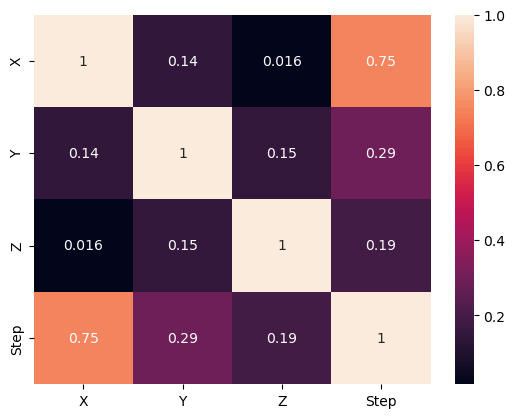

In [11]:
#Generate a heatmap for the correlation matrix 
sns.heatmap(np.abs(corr_matrix), annot = True)

# Training Data Preparation

Before performing any prepatory transformations of the datset, they first need to be split between observations and labels

In [12]:
X_train = train_set.drop("Step", axis = 1)
X_test = test_set.drop("Step", axis = 1)

y_train = train_set["Step"].copy()
y_test = test_set["Step"].copy()

In order to prepare the data for a training model, it first needs to be scaled, as the range of the different coordinate axes have different scales.

In [69]:
#Scaling the features for the test and train sets

min_max_scaler = MinMaxScaler()

X_train_prep = min_max_scaler.fit_transform(X_train)
X_test_prep = min_max_scaler.transform(X_test)

# Model Training

Developing and Evaluating RandomForestClassifier

In [14]:
#GridSearchCV to develop an optimized RandomForestClassifier
rf_clf  = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [10, 100], 
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 3, 5]
    
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'f1': 'f1_macro'
}

grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring=scoring, refit='accuracy')

grid_search_rf.fit(X_train_prep, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [10, 100]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro'})

In [15]:
#Tuning rf_clf
grid_search_rf.best_params_

best_rf = grid_search_rf.best_estimator_

In [16]:
#Predictions of the RandomForest Classifier on the train and test data 
y_train_pred_rf = best_rf.predict(X_train_prep)
y_test_pred_rf = best_rf.predict(X_test_prep)

In [17]:
#Evaluationg accuracy, precision, and f1 score of rf_clf
rep_rf_train = classification_report(y_train, y_train_pred_rf, zero_division=1, output_dict=True)
rep_rf_test = classification_report(y_test, y_test_pred_rf, zero_division=1, output_dict=True)

rep_rf_train_df = pd.DataFrame(rep_rf_train).transpose()
rep_rf_test_df = pd.DataFrame(rep_rf_test).transpose()

print(rep_rf_test_df)

              precision    recall  f1-score     support
1              1.000000  0.800000  0.888889    5.000000
2              0.833333  1.000000  0.909091    5.000000
3              1.000000  1.000000  1.000000    5.000000
4              1.000000  1.000000  1.000000    5.000000
5              0.833333  1.000000  0.909091    5.000000
6              1.000000  0.750000  0.857143    4.000000
7              1.000000  1.000000  1.000000   29.000000
8              1.000000  1.000000  1.000000   44.000000
9              1.000000  1.000000  1.000000   50.000000
10             1.000000  1.000000  1.000000    5.000000
11             1.000000  1.000000  1.000000    5.000000
12             1.000000  1.000000  1.000000    5.000000
13             1.000000  1.000000  1.000000    5.000000
accuracy       0.988372  0.988372  0.988372    0.988372
macro avg      0.974359  0.965385  0.966478  172.000000
weighted avg   0.990310  0.988372  0.988162  172.000000


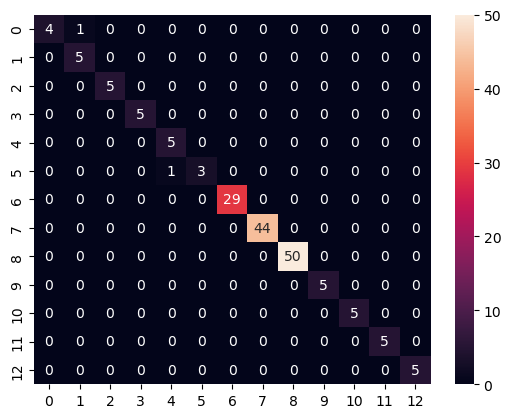

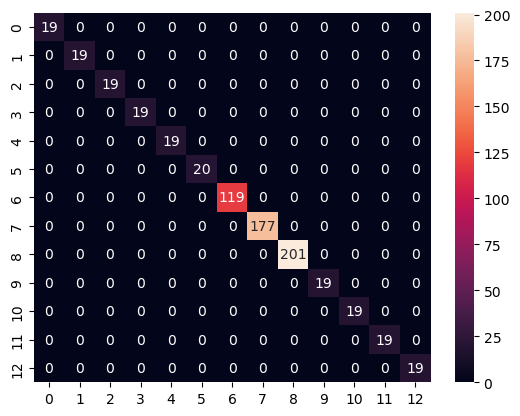

In [18]:
#create a confusion matrix for the rf_clf
conf_mat_train_rf = confusion_matrix(y_train, y_train_pred_rf)
conf_mat_test_rf = confusion_matrix(y_test, y_test_pred_rf)

sns.heatmap(conf_mat_test_rf, annot=True)
plt.show()
sns.heatmap(conf_mat_train_rf, annot=True, fmt='g')
plt.show()

Developing and Evaluating SVM Classifier

In [19]:
#Developing an SVM Classifier
svm_clf = SVC(random_state=42)

param_grid_svc = {
    'C': [0.5, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [1, 10, 100, 200]
}

precision_scorer = make_scorer(precision_score, average='weighted', zero_division = 1)

scoring_svm = {
    'accuracy': 'accuracy',
    'precision': precision_scorer,
    'f1': 'f1_macro'
}


grid_search_svc = GridSearchCV(svm_clf, param_grid_svc, cv=5, scoring=scoring_svm, refit='accuracy')

grid_search_svc.fit(X_train_prep, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.5, 0.1, 1, 10, 100],
                         'gamma': [1, 10, 100, 200],
                         'kernel': ['linear', 'rbf', 'poly']},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted, zero_division=1)})

In [20]:
#Tuning svc
grid_search_svc.best_params_

best_svc = grid_search_svc.best_estimator_

In [21]:
#Generating predictions with svc
y_train_pred_svc = best_svc.predict(X_train_prep)
y_test_pred_svc = best_svc.predict(X_test_prep)

In [45]:
#Get performance report for svc
rep_svc_train = classification_report(y_train, y_train_pred_svc, output_dict=True)
rep_svc_test = classification_report(y_test, y_test_pred_svc, output_dict=True)

rep_svc_train_df = pd.DataFrame(rep_svc_train).transpose()
rep_svc_test_df = pd.DataFrame(rep_svc_test).transpose()

print(rep_svc_test_df)

              precision  recall  f1-score  support
1                   1.0     1.0       1.0      5.0
2                   1.0     1.0       1.0      5.0
3                   1.0     1.0       1.0      5.0
4                   1.0     1.0       1.0      5.0
5                   1.0     1.0       1.0      5.0
6                   1.0     1.0       1.0      4.0
7                   1.0     1.0       1.0     29.0
8                   1.0     1.0       1.0     44.0
9                   1.0     1.0       1.0     50.0
10                  1.0     1.0       1.0      5.0
11                  1.0     1.0       1.0      5.0
12                  1.0     1.0       1.0      5.0
13                  1.0     1.0       1.0      5.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    172.0
weighted avg        1.0     1.0       1.0    172.0


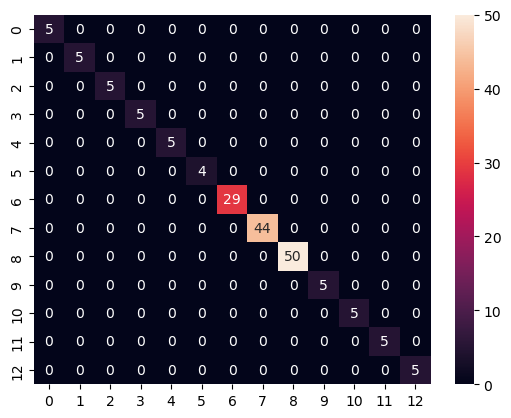

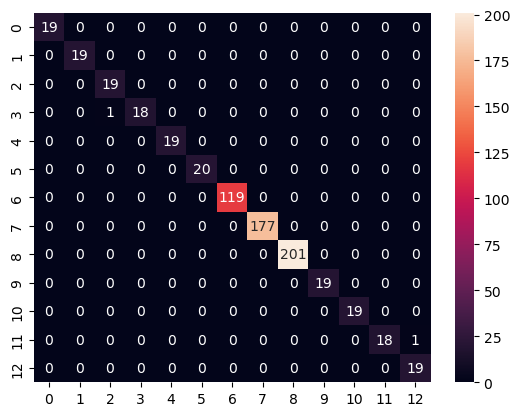

In [85]:
#create a confusion matrix for the svc_clf
conf_mat_train_svc = confusion_matrix(y_train, y_train_pred_svc)
conf_mat_test_svc = confusion_matrix(y_test, y_test_pred_svc)

sns.heatmap(conf_mat_test_svc, annot=True)
plt.show()
sns.heatmap(conf_mat_train_svc, annot=True, fmt='g')
plt.show()

Training and evaluating CNB classifier

In [34]:
#Using gridsearch to train an CNB classifier
cnb_clf = ComplementNB()

param_grid = [
    {'alpha': [1000, 1500, 2000, 2500]},
    {'norm': [True, False]}
]

grid_search_cnb = GridSearchCV(cnb_clf, param_grid, cv=5, scoring='accuracy', refit='accuracy')

grid_search_cnb.fit(X_train_prep, y_train)

grid_search_cnb.best_params_

print(grid_search_cnb.best_score_)

best_cnb = grid_search_cnb.best_estimator_

0.6948164603829472


In [36]:
#Generating predictions with cnb_clf
y_train_pred_cnb = best_cnb.predict(X_train_prep)
y_test_pred_cnb = best_cnb.predict(X_test_prep)

In [38]:
#Evaluationg accuracy, precision, and f1 score of cnb_clf
rep_cnb_train = classification_report(y_train, y_train_pred_cnb, zero_division=1, output_dict=True)
rep_cnb_test = classification_report(y_test, y_test_pred_cnb, zero_division=1, output_dict=True)

rep_cnb_train_df = pd.DataFrame(rep_cnb_train).transpose()
rep_cnb_test_df = pd.DataFrame(rep_cnb_test).transpose()

print(rep_cnb_test_df)

              precision    recall  f1-score     support
1              1.000000  0.000000  0.000000    5.000000
2              1.000000  0.000000  0.000000    5.000000
3              1.000000  0.000000  0.000000    5.000000
4              1.000000  0.000000  0.000000    5.000000
5              1.000000  0.000000  0.000000    5.000000
6              0.307692  1.000000  0.470588    4.000000
7              0.725000  1.000000  0.840580   29.000000
8              0.673469  0.750000  0.709677   44.000000
9              1.000000  1.000000  1.000000   50.000000
10             1.000000  0.000000  0.000000    5.000000
11             1.000000  0.000000  0.000000    5.000000
12             1.000000  0.000000  0.000000    5.000000
13             0.250000  1.000000  0.400000    5.000000
accuracy       0.703488  0.703488  0.703488    0.703488
macro avg      0.842782  0.365385  0.263142  172.000000
weighted avg   0.832200  0.703488  0.636541  172.000000


Training and evaluating GNB Classifier

In [40]:
#Using randomizedsearchcv to develop GNB classifier
gnb_clf = GaussianNB()

param_grid_gnb = [
    {'var_smoothing': np.logspace(0, -9, num=100)}
]

rand_search_gnb = RandomizedSearchCV(gnb_clf, param_grid_gnb, scoring='accuracy')

rand_search_gnb.fit(X_train_prep, y_train)

print(rand_search_gnb.best_params_)

print(rand_search_gnb.best_score_)

best_gnb = rand_search_gnb.best_estimator_

{'var_smoothing': 0.0006579332246575676}
0.9898339151592086


In [41]:
#Getting predictions for gnb
y_train_pred_gnb = best_gnb.predict(X_train_prep)
y_test_pred_gnb = best_gnb.predict(X_test_prep)

In [42]:
#Evaluationg accuracy, precision, and f1 score of cnb_clf
rep_gnb_train = classification_report(y_train, y_train_pred_gnb, zero_division=1, output_dict=True)
rep_gnb_test = classification_report(y_test, y_test_pred_gnb, zero_division=1, output_dict=True)

rep_gnb_train_df = pd.DataFrame(rep_gnb_train).transpose()
rep_gnb_test_df = pd.DataFrame(rep_gnb_test).transpose()

print(rep_gnb_test_df)

              precision    recall  f1-score     support
1              1.000000  1.000000  1.000000    5.000000
2              1.000000  1.000000  1.000000    5.000000
3              1.000000  1.000000  1.000000    5.000000
4              1.000000  1.000000  1.000000    5.000000
5              0.833333  1.000000  0.909091    5.000000
6              1.000000  0.750000  0.857143    4.000000
7              1.000000  1.000000  1.000000   29.000000
8              1.000000  1.000000  1.000000   44.000000
9              1.000000  1.000000  1.000000   50.000000
10             1.000000  1.000000  1.000000    5.000000
11             1.000000  1.000000  1.000000    5.000000
12             1.000000  1.000000  1.000000    5.000000
13             1.000000  1.000000  1.000000    5.000000
accuracy       0.994186  0.994186  0.994186    0.994186
macro avg      0.987179  0.980769  0.982018  172.000000
weighted avg   0.995155  0.994186  0.994035  172.000000


Stacked Model

In [60]:
stacked_estimators = [
    ('rf', best_rf),
    ('gnb', best_gnb)
]

stacked_clf = StackingClassifier(estimators=stacked_estimators, final_estimator=LogisticRegression(max_iter = 1000))

stacked_clf.fit(X_train_prep, y_train)

cross_val_score(stacked_clf, X_train_prep, y_train, cv=5)

array([0.99275362, 0.97826087, 0.99275362, 0.99270073, 0.99270073])

In [61]:
#Predictions from the stacked model
y_train_pred_stk = stacked_clf.predict(X_train_prep)
y_test_pred_stk = stacked_clf.predict(X_test_prep)

In [62]:
#Evaluationg accuracy, precision, and f1 score of cnb_clf
rep_stk_train = classification_report(y_train, y_train_pred_stk, zero_division=1, output_dict=True)
rep_stk_test = classification_report(y_test, y_test_pred_stk, zero_division=1, output_dict=True)

rep_stk_train_df = pd.DataFrame(rep_stk_train).transpose()
rep_stk_test_df = pd.DataFrame(rep_stk_test).transpose()

print(rep_stk_test_df)

              precision    recall  f1-score     support
1              1.000000  0.800000  0.888889    5.000000
2              0.833333  1.000000  0.909091    5.000000
3              1.000000  1.000000  1.000000    5.000000
4              1.000000  1.000000  1.000000    5.000000
5              0.833333  1.000000  0.909091    5.000000
6              1.000000  0.750000  0.857143    4.000000
7              1.000000  1.000000  1.000000   29.000000
8              1.000000  1.000000  1.000000   44.000000
9              1.000000  1.000000  1.000000   50.000000
10             1.000000  1.000000  1.000000    5.000000
11             1.000000  1.000000  1.000000    5.000000
12             1.000000  1.000000  1.000000    5.000000
13             1.000000  1.000000  1.000000    5.000000
accuracy       0.988372  0.988372  0.988372    0.988372
macro avg      0.974359  0.965385  0.966478  172.000000
weighted avg   0.990310  0.988372  0.988162  172.000000


Creating a pipeline of the best model and saving it to a joblib

In [84]:
final_model = Pipeline(steps=[
    ('scaler', min_max_scaler),
    ('model', best_svc)
])

test_sample = np.array([9.375, 3.0625, 0.5]).reshape(1, -1)

final_model.predict(test_sample)

joblib.dump(final_model, 'final_model.joblib')

c:\Users\ahadr\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


['final_model.joblib']